Cleaned DataFrame:
   Order_ID Customer_Name                   Email       Phone  \
0       101      John Doe          john@email.com  9876543210   
1       102   Alice Smith  not_provided@email.com  9898989898   
2       103    Bob Miller           bob@email.com     Unknown   
4       105   David White         david@email.com  9123456789   
5       106    Emma Brown          emma@email.com  9234567890   
6       107   Chris Green  not_provided@email.com  9345678901   
7       108   Alice Smith         alice@email.com     Unknown   

  Product_Category  Order_Date  Revenue  Discount (%)  
0      Electronics  2023-12-31     1200          10.0  
1         Clothing  2024-01-05      500           0.0  
2      Electronics  2024-01-12     3000          20.0  
4        Furniture  2024-02-15     2500          15.0  
5         Clothing  2024-03-08      700           5.0  
6        Furniture  2024-04-10     1800          25.0  
7         Clothing  2024-03-08      500           0.0  

Cleaned CSV

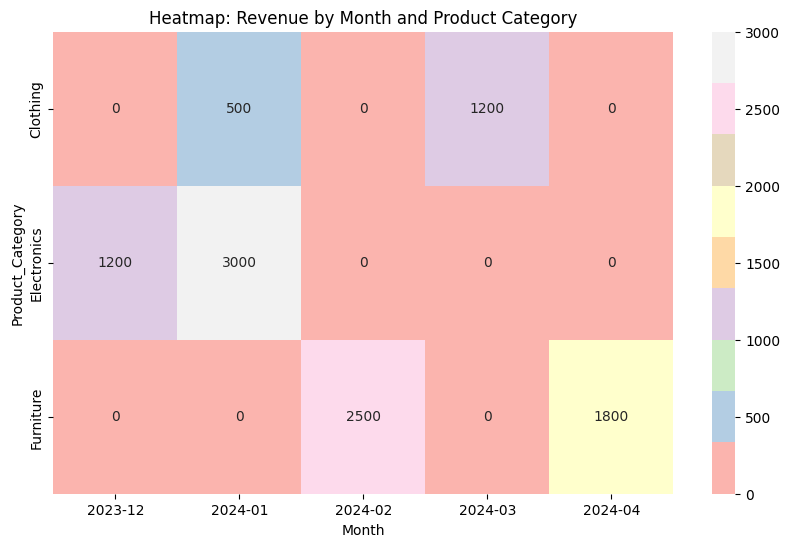

Heatmap saved as 'heatmap.png'


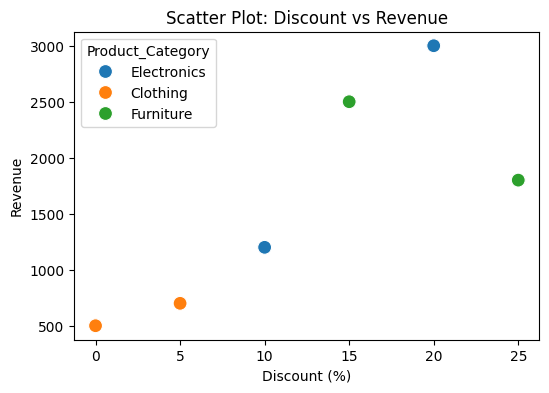

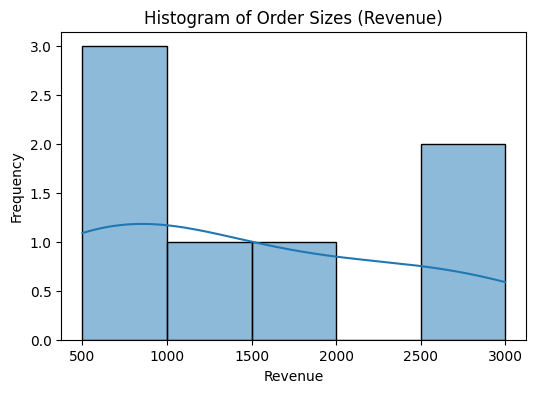

In [ ]:
import pandas as pd
from io import StringIO
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Raw data
csv_data = """Order_ID,Customer_Name,Email,Phone,Product_Category,Order_Date,Revenue,Discount (%)
101,John Doe,john@email.com,9876543210,Electronics,12/31/2023,1200,10.0
102,Alice Smith,,9898989898,Clothing,01-05-2024,500,
103,Bob Miller,bob@email.com,,Electronics,2024/01/12,3000,20.0
104,John Doe,john@email.com,9876543210,Electronics,12/31/2023,1200,10.0
105,David White,david@email.com,9123456789,Furniture,02-15-2024,2500,15.0
106,Emma Brown,emma@email.com,9234567890,Clothing,2024-03-08,700,5.0
107,Chris Green,,9345678901,Furniture,04/10/2024,1800,25.0
108,Alice Smith,alice@email.com,,Clothing,03-08-2024,500,"""

# Load into DataFrame
df = pd.read_csv(StringIO(csv_data), dtype={'Phone': str})

# Handle missing values
df['Email'] = df['Email'].fillna('not_provided@email.com')
df['Phone'] = df['Phone'].fillna('Unknown')
df['Discount (%)'] = df['Discount (%)'].fillna(0)

# Remove duplicates (keep min Order_ID)
df = df.sort_values('Order_ID').drop_duplicates(subset=df.columns[1:])

# Standardize dates
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='mixed', errors='coerce')
df['Order_Date'] = df['Order_Date'].dt.strftime('%Y-%m-%d')

# Display cleaned DataFrame
print("Cleaned DataFrame:")
print(df)

# Save cleaned CSV
df.to_csv('cleaned_sales_data.csv', index=False)
print("\nCleaned CSV saved as 'cleaned_sales_data.csv'")

# Set up SQLite
conn = sqlite3.connect(':memory:')
df.to_sql('sales_data', conn, index=False)

# Aggregation Queries
print("\nAggregation Results:")

# Total revenue per product category
query1 = """
SELECT Product_Category, SUM(Revenue) AS Total_Revenue
FROM sales_data
GROUP BY Product_Category;
"""
result1 = pd.read_sql_query(query1, conn)
print("\nTotal Revenue per Category:")
print(result1)

# Average discount across categories
query2 = """
SELECT Product_Category, AVG("Discount (%)") AS Avg_Discount
FROM sales_data
GROUP BY Product_Category;
"""
result2 = pd.read_sql_query(query2, conn)
print("\nAverage Discount per Category:")
print(result2)

# Monthly sales trends
query3 = """
SELECT strftime('%Y-%m', Order_Date) AS Month, SUM(Revenue) AS Total_Sales
FROM sales_data
GROUP BY Month
ORDER BY Month;
"""
result3 = pd.read_sql_query(query3, conn)
print("\nMonthly Sales Trends:")
print(result3)

# Visualizations

# Heatmap
df['Month'] = pd.to_datetime(df['Order_Date']).dt.to_period('M').astype(str)
pivot = df.pivot_table(values='Revenue', index='Product_Category', columns='Month', aggfunc='sum', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='g', cmap='Pastel1')
plt.title('Heatmap: Revenue by Month and Product Category')
plt.savefig('heatmap.png')
plt.show()
print("Heatmap saved as 'heatmap.png'")

# 2. Scatter Plot (Discount % vs Revenue)
plt.figure(figsize=(6,4))
sns.scatterplot(x="Discount (%)", y="Revenue", hue="Product_Category", data=df, s=100)
plt.title("Scatter Plot: Discount vs Revenue")
plt.savefig("scatter.png")
plt.show()

# 3. Histogram (Revenue distribution)
plt.figure(figsize=(6,4))
sns.histplot(df["Revenue"], bins=5, kde=True)
plt.title("Histogram of Order Sizes (Revenue)")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.savefig("histogram.png")
plt.show()